# ndcube Tutorial (Abbreviated)

This notebook gives a rapid introduction to the `ndcube` package which provides a framework for inspecting, analyzing and visualizing n-dimensional data.  It walks through the two primary classes of the `ndcube` package: `NDCube` and `NDCubeSequence`.

In [53]:
# Import packages we will be using this tutorial here.
from datetime import datetime, timedelta

import numpy as np
from astropy.io import fits
import astropy.wcs
import astropy.units as u
import matplotlib.pyplot as plt
from sunpy.time import parse_time
from sunpy.visualization.imageanimator import ImageAnimatorWCS

from ndcube import NDCube, NDCubeSequence

In [54]:
# Enable interactive plotting windows within the notebook.
% matplotlib notebook

Before we start, let's read in some IRIS spectrograph data that we will use throughout this tutorial as an example.

In [55]:
# Define the filepath and filename for data which we will use in this tutorial.
filename0 = "iris_l2_20141211_191222_3803105278_raster_t000_r00000.fits"
filename1 = "iris_l2_20141211_191222_3803105278_raster_t000_r00001.fits"
filename2 = "iris_l2_20141211_191222_3803105278_raster_t000_r00002.fits"

## Data Used In This Tutorial: IRIS, A Scanning Slit Spectrometer

IRIS is a solar scanning slit spectrometer instrument that simulataneous takes images and spectrograms of the Sun in UV wavelengths.  Spectra are produced via a diffraction slit, that can be moved in steps (rastered) across the Sun to get spectra from different locations.  Once all the slit has been pointed at all the designated positions, the instrument goes back to the first slit position and starts again.

#### Show SJI movie & spectrogram

## NDCube

The ndcube package contains two basic classes for handling ND data: `NDCube` and `NDCubeSequence`.  `NDCube` is the fundamental class of the ndcube package and is designed to handle data contained in a single N-D array described by a single set of WCS transformation.  `NDCube` is subclassed from `astropy.nddata.NDData` and so inherits the same attributes for data, wcs, uncertainty, mask, meta, and unit.  The WCS object contained in the ``.wcs`` attribute is subclassed from `astropy.wcs.WCS` and contains a few additional attributes to enable to keep track of its relationship to the data.

### Initialization

To initialize the most basic `NDCube` object, all you need is a `numpy.ndarray` containing the data, and an `astropy.wcs.WCS` object describing the transformation from array-element space to real world coordinates.  Let's use the data we've explored already to make an `NDCube`.

In [56]:
# Read data from file.
hdulist = fits.open(filename0)
data = hdulist[1].data
input_wcs = astropy.wcs.WCS(hdulist[1].header)
hdulist.close()

In [57]:
# Create an NDCube.
my_cube = NDCube(data, input_wcs)

In [58]:
my_cube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  274.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 333  548  8
---------------------
Length of NDCube: [  8. 548. 333.] pix
Axis Types of NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

The data array is stored in the ``mycube.data`` attribute while the WCS object is stored in the ``my_cube.wcs`` attribute.

In [59]:
my_cube.data

array([[[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],

       [[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.]],

       [[-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -200., -200.],
        ...,
        [-200., -200., -200., ..., -200., -200., -200.],
        [-200., -200., -200., ..., -200., -20

In [60]:
my_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  274.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 333  548  8

Thanks to the fact that `NDCube` is subclassed from `astropy.nddata.NDData`, you can also supply additional data to the `NDCube` instance.  These include: 
* metadata (`dict` or dict-like) located at `NDCube.meta`;
* a data mask (boolean `numpy.ndarray`) located at`NDCube.mask` highlighting, for example, reliable and unreliable pixels; 
* an uncertainty array (`numpy.ndarray`) located at `NDCube.uncertainty` describing the uncertainty of each data array value; and a unit (`astropy.units.Unit` or unit `str`). 

For example:

In [61]:
# Mask out pixels with -200 values.
mask = my_cube.data == -200
# Generate metadata
meta = {"Description": "This is example NDCube metadata."}
# Create NDCube with uncertainty, mask and meta
my_cube = NDCube(data, input_wcs, uncertainty=np.sqrt(data), mask=mask, meta=meta)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [62]:
my_cube.mask

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [63]:
my_cube.meta

{'Description': 'This is example NDCube metadata.'}

### Dimensions

`NDCube` has useful properties for inspecting its data shape and axis types, namely `NDCube.dimensions` and `NDCube.world_axis_physical_types`:

In [64]:
my_cube.dimensions

<Quantity [  8., 548., 333.] pix>

In [65]:
my_cube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

`NDCube.dimensions` returns an `Quantity` of pixel units giving the length of each dimension in the `NDCube` while `NDCube.world_axis_physical_types` returns an iterable of strings denoting the type of physical property represented by each axis.  The axis names are in accordance with the International Virtual Observatory Alliance (IVOA) UCD1+ controlled vocabulary (http://www.ivoa.net/documents/REC/UCD/UCDlist-20070402.html). Here the shape and axis types are given in data order, not WCS order.

### Slicing

Arguably NDCube's most powerful capability is its slicing.  Slicing an `NDCube` instance using the standard slicing notation allows users to access sub-regions of their data while simultaneously slicing not only the other array attributes (e.g. uncertainty, mask, etc.) but also the WCS object.  This ensures that even though the data array has changed size and shape, each array element will still correspond to the same real world coordinates as they did before.  An example of how to slice a 3-D `NDCube` object is:

In [66]:
my_cube_roi = my_cube[3:5, 10:100, 30:37]
my_cube_roi.dimensions

<Quantity [ 2., 90.,  7.] pix>

Slicing can also reduce the dimension of an `NDCube`, e.g.:

In [67]:
my_2d_cube = my_cube[0, 10:100, 30:37]
my_2d_cube.dimensions

<Quantity [90.,  7.] pix>

In [83]:
my_2d_cube.world_axis_physical_types

('custom:pos.helioprojective.lat', 'em.wl')

In [85]:
my_2d_cube.pixel_to_world(u.Quantity([3, 6], unit=u.pix), u.Quantity([4, 7], unit=u.pix))

[<Quantity [-0.09654027, -0.09626304] deg>,
 <Quantity [1.33278264e-07, 1.33286052e-07] m>]

In [84]:
my_2d_cube.missing_axis

[False, False, True]

In [86]:
my_2d_cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : -29.0  264.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 7  90  1

In [87]:
my_cube[:, 10:100, 0].wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07246722222222222  0.003416111111111111  
CRPIX : 1.0  264.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338277805205  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376150493276  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 1  90  8

In addition to slicing by index, `NDCube` supports a basic version of slicing/indexing by real world coordinates via the `NDCube.crop_by_coords` method.  This takes a list of `astropy.units.Quantity` instances representing the minimum real world coordinates of the region of interest in each dimension.  The order of the coordinates must be the same as the order of the data axes.  A second iterable of `Quantities` must also be provided which gives the widths of the region of interest in each data axis:

In [68]:
my_cube_roi = my_cube.crop_by_coords(
    [u.Quantity(0.003, unit="deg"), u.Quantity(-0.09, unit="deg"), u.Quantity(1.333e-7, unit="m")],
    [u.Quantity(0.001, unit="deg"), u.Quantity(0.04, unit="deg"), u.Quantity(0.001e-7, unit="m")])
my_cube_roi.dimensions

<Quantity [  2., 433.,  39.] pix>

This method does not rebin or interpolate the data if the region of interest does not perfectly map onto the array's "pixel" grid.  Instead it translates from real world to pixel coordinates and rounds to the nearest integer pixel before indexing/slicing the `NDCube` instance. Therefore it should be noted that slightly different inputs to this method can result in the same output.

### Coordinate Transformations

#### NDCube.pixel_to_world

To convert two pixels with pixel coordinates (2, 3, 4) and (5, 6, 7), we would call pixel_to_world like so:

In [69]:
real_world_coords = my_cube.pixel_to_world(u.Quantity([2, 5], unit=u.pix), 
                                           u.Quantity([3, 6], unit=u.pix), 
                                           u.Quantity([4, 7], unit=u.pix))
real_world_coords

[<Quantity [0.00285699, 0.0036915 ] deg>,
 <Quantity [-0.09746126, -0.0971934 ] deg>,
 <Quantity [1.33200384e-07, 1.33208172e-07] m>]

#### NDCube.world_to_pixel

Using `world_to_pixel` to convert real world coordinates to pixel coordinates is exactly the same, but in reverse.

In [70]:
pixel_coords = my_cube.world_to_pixel(u.Quantity(1.40006967, unit="deg"), 
                                      u.Quantity(1.49986193, unit="deg"),
                                      u.Quantity(1.10000000e-09,  unit="m"))
pixel_coords

[<Quantity 4979.25113962 pix>,
 <Quantity 17465.4751099 pix>,
 <Quantity -50882.12634823 pix>]

#### NDCube.axis_world_coords

To get real world values of all pixels along one or more axes, use `NDCube.all_world_coords`.

In [71]:
axes_rwc = my_cube.axis_world_coords()
axes_rwc

(<Quantity [[0.00229961, 0.00230065, 0.00230169, ..., 0.00286776,
             0.0028688 , 0.00286985],
            [0.00257674, 0.00257778, 0.00257882, ..., 0.00314489,
             0.00314593, 0.00314697],
            [0.00285386, 0.00285491, 0.00285595, ..., 0.00342202,
             0.00342306, 0.0034241 ],
            ...,
            [0.00368525, 0.00368629, 0.00368733, ..., 0.0042534 ,
             0.00425444, 0.00425548],
            [0.00396238, 0.00396342, 0.00396446, ..., 0.00453053,
             0.00453157, 0.00453261],
            [0.0042395 , 0.00424055, 0.00424159, ..., 0.00480765,
             0.0048087 , 0.00480974]] deg>,
 <Quantity [[-0.09773224, -0.09763983, -0.09754742, ..., -0.04736827,
             -0.04727586, -0.04718345],
            [-0.09773536, -0.09764295, -0.09755054, ..., -0.0473714 ,
             -0.04727899, -0.04718658],
            [-0.09773849, -0.09764608, -0.09755367, ..., -0.04737452,
             -0.04728211, -0.0471897 ],
            ...,
      

In [20]:
(axes_rwc[0].shape, my_cube.world_axis_physical_types[0]), \
(axes_rwc[1].shape, my_cube.world_axis_physical_types[1]), \
(axes_rwc[2].shape, my_cube.world_axis_physical_types[2])

(((8, 548), 'custom:pos.helioprojective.lon'),
 ((8, 548), 'custom:pos.helioprojective.lat'),
 ((333,), 'em.wl'))

Choose which axes to get get real world coordinates for by giving axis number or a substring unique to the axis's physical type:

In [72]:
my_cube.axis_world_coords(2)

<Quantity [1.33190000e-07, 1.33192596e-07, 1.33195192e-07, 1.33197788e-07,
           1.33200384e-07, 1.33202980e-07, 1.33205576e-07, 1.33208172e-07,
           1.33210768e-07, 1.33213364e-07, 1.33215960e-07, 1.33218556e-07,
           1.33221152e-07, 1.33223748e-07, 1.33226344e-07, 1.33228940e-07,
           1.33231536e-07, 1.33234132e-07, 1.33236728e-07, 1.33239324e-07,
           1.33241920e-07, 1.33244516e-07, 1.33247112e-07, 1.33249708e-07,
           1.33252304e-07, 1.33254900e-07, 1.33257496e-07, 1.33260092e-07,
           1.33262688e-07, 1.33265284e-07, 1.33267880e-07, 1.33270476e-07,
           1.33273072e-07, 1.33275668e-07, 1.33278264e-07, 1.33280860e-07,
           1.33283456e-07, 1.33286052e-07, 1.33288648e-07, 1.33291244e-07,
           1.33293840e-07, 1.33296436e-07, 1.33299032e-07, 1.33301628e-07,
           1.33304224e-07, 1.33306820e-07, 1.33309416e-07, 1.33312012e-07,
           1.33314608e-07, 1.33317204e-07, 1.33319800e-07, 1.33322396e-07,
           1.33324992e-07

In [73]:
# Since 'wl' is unique to the wavelength axis name, let's use that.
my_cube.axis_world_coords('wl')

<Quantity [1.33190000e-07, 1.33192596e-07, 1.33195192e-07, 1.33197788e-07,
           1.33200384e-07, 1.33202980e-07, 1.33205576e-07, 1.33208172e-07,
           1.33210768e-07, 1.33213364e-07, 1.33215960e-07, 1.33218556e-07,
           1.33221152e-07, 1.33223748e-07, 1.33226344e-07, 1.33228940e-07,
           1.33231536e-07, 1.33234132e-07, 1.33236728e-07, 1.33239324e-07,
           1.33241920e-07, 1.33244516e-07, 1.33247112e-07, 1.33249708e-07,
           1.33252304e-07, 1.33254900e-07, 1.33257496e-07, 1.33260092e-07,
           1.33262688e-07, 1.33265284e-07, 1.33267880e-07, 1.33270476e-07,
           1.33273072e-07, 1.33275668e-07, 1.33278264e-07, 1.33280860e-07,
           1.33283456e-07, 1.33286052e-07, 1.33288648e-07, 1.33291244e-07,
           1.33293840e-07, 1.33296436e-07, 1.33299032e-07, 1.33301628e-07,
           1.33304224e-07, 1.33306820e-07, 1.33309416e-07, 1.33312012e-07,
           1.33314608e-07, 1.33317204e-07, 1.33319800e-07, 1.33322396e-07,
           1.33324992e-07

In [74]:
my_cube.world_axis_physical_types

('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

### Plotting

Use `NDCube.plot` to produce a sensible visualization based on the dimensionality of the data.

The type of visualization returned depends on the dimensionality of the data within the `NDCube` object.  For an NDCube of dimensions > 2, a 2D animation can be produced:

<IPython.core.display.Javascript object>


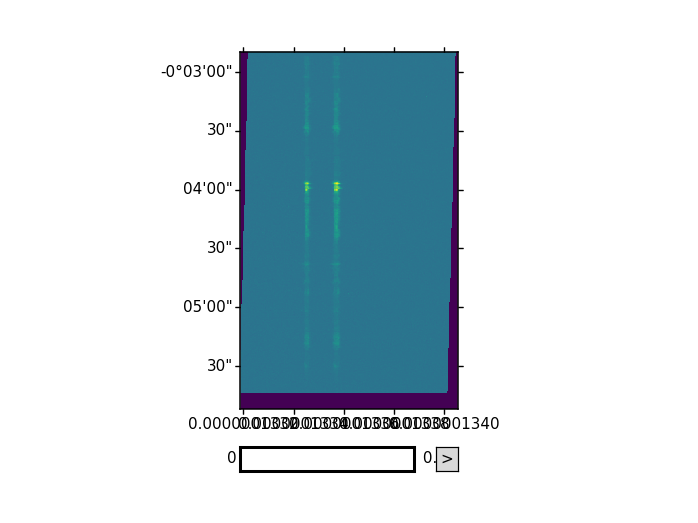

In [75]:
# Visualize all in the NDCube as an animation.
my_cube.plot()

For an 2D `NDCube` an image can be produced:

<IPython.core.display.Javascript object>


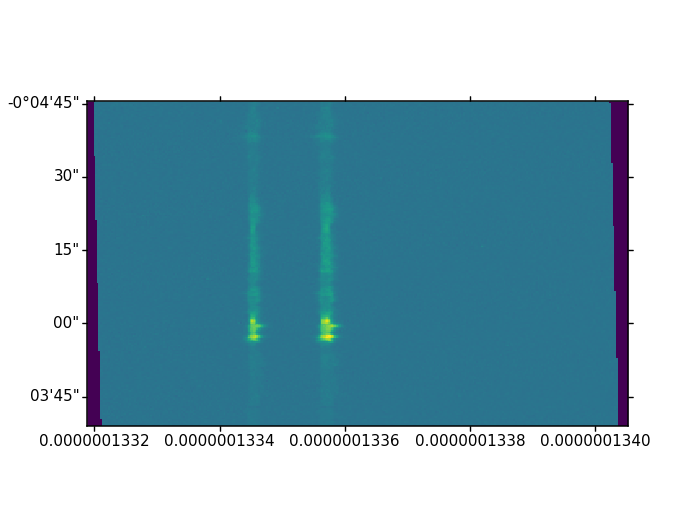

In [76]:
# Plot a subregion of the 0th exposure as a 2D image.
my_cube[0, 200:400, :].plot()

For an 1D `NDCube` a line plot can be produced:

<IPython.core.display.Javascript object>


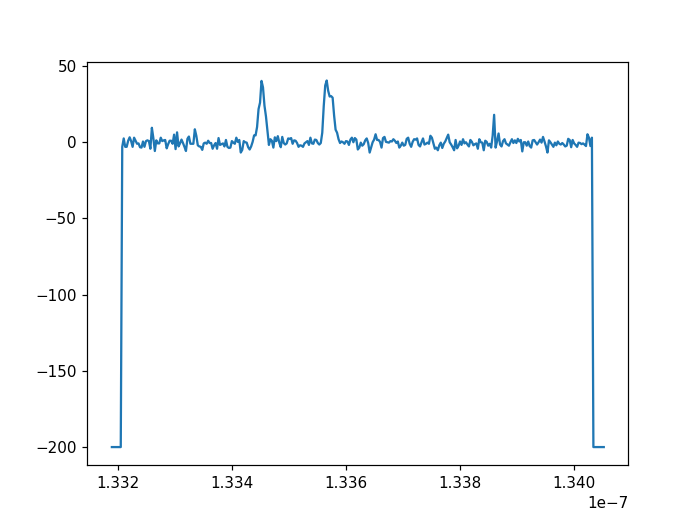

In [77]:
# Plot a 1D spectrum from a single latitude in the 0th exposure.
my_cube[0, 350, :].plot()

### Extra Coordinates

Attach coordinates to axes that are not included in the WCS transformation.

For example, in the case of IRIS, the x-axis corresponds to longitude in the WCS transformations, but also corresponds to time as it takes time to move the slit and take another exposure.

In [78]:
# Define our timestamps.  Must be same length as data axis.
axis_length = int(my_cube.dimensions[0].value)
timestamps = [datetime(2000, 1, 1)+timedelta(minutes=i) for i in range(axis_length)]
extra_coords_input = [("time", 0, timestamps)]
# Generate NDCube as above, except now set extra_coords kwarg.
my_cube = NDCube(data, input_wcs, uncertainty=np.sqrt(data), mask=mask, meta=meta, unit=None, 
                 extra_coords=extra_coords_input)

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [79]:
timestamps

[datetime.datetime(2000, 1, 1, 0, 0),
 datetime.datetime(2000, 1, 1, 0, 1),
 datetime.datetime(2000, 1, 1, 0, 2),
 datetime.datetime(2000, 1, 1, 0, 3),
 datetime.datetime(2000, 1, 1, 0, 4),
 datetime.datetime(2000, 1, 1, 0, 5),
 datetime.datetime(2000, 1, 1, 0, 6),
 datetime.datetime(2000, 1, 1, 0, 7)]

The `NDCube.extra_coords` property returns a `dict` where each key is a coordinate name entered by the user.  The value of each key is itself another dictionary with keys ``'axis'`` and ``'value'`` giving the corresponding data axis number and coordinate value at each pixel as supplied by the user:

In [80]:
my_cube.extra_coords

{'time': {'axis': 0,
  'value': [datetime.datetime(2000, 1, 1, 0, 0),
   datetime.datetime(2000, 1, 1, 0, 1),
   datetime.datetime(2000, 1, 1, 0, 2),
   datetime.datetime(2000, 1, 1, 0, 3),
   datetime.datetime(2000, 1, 1, 0, 4),
   datetime.datetime(2000, 1, 1, 0, 5),
   datetime.datetime(2000, 1, 1, 0, 6),
   datetime.datetime(2000, 1, 1, 0, 7)]}}

Just like the data array and the WCS object, the extra coordinates are sliced automatically when the `NDCube` instance is sliced.  So if we take the first slice of ``my_cube`` in the 0th axis, the extra time coordinate will only contain the value from that slice.

In [81]:
my_cube[0].extra_coords

{'time': {'axis': None, 'value': datetime.datetime(2000, 1, 1, 0, 0)}}

Note that the ``axis`` value is now ``None`` because the dimensionality of the `NDCube` has been reduced via the slicing

In [82]:
my_cube[0].dimensions

<Quantity [548., 333.] pix>

and so the ``time`` extra coordinate no longer corresponds to a data axis.  This would not have been the case if we had done the slicing so the length of the 0th axis was >1.

In [32]:
my_cube[0:2].dimensions

<Quantity [  2., 548., 333.] pix>

In [33]:
my_cube[0:2].extra_coords

{'time': {'axis': 0,
  'value': [datetime.datetime(2000, 1, 1, 0, 0),
   datetime.datetime(2000, 1, 1, 0, 1)]}}

## NDCubeSequence

`NDCubeSequence` is a class for handling multiple `NDCube` objects as though they were one contiguous data set. Another way of thinking about it is that `NDCubeSequence` provides the ability to manipulate a data set described by multiple separate WCS transformations.

Regarding implementation, an `NDCubeSequence` instance is effectively a list of `NDCube` instances with some helper methods attached.

### Initialization

To initialize the most basic `NDCubeSequence` object, all you need is a list of `NDCube` instances.

In [88]:
ext_num = 1

In [89]:
aux_ext_num = -2

In [90]:
# Define function to extract measurement times from IRIS FITS files.
def extract_iris_times_from_fits(hdulist, aux_ext_num=-2):
    return np.array([parse_time(hdulist[0].header["STARTOBS"]) + timedelta(seconds=i) 
                     for i in hdulist[aux_ext_num].data[:, hdulist[aux_ext_num].header["TIME"]]])

In [91]:
# Read data from files.
hdulist0 = fits.open(filename0)
data0 = hdulist[ext_num].data
input_wcs0 = astropy.wcs.WCS(hdulist0[ext_num].header)
timestamps0 = extract_iris_times_from_fits(hdulist0)
hdulist0.close()

hdulist1 = fits.open(filename1)
data1 = hdulist1[ext_num].data
input_wcs1 = astropy.wcs.WCS(hdulist1[ext_num].header)
timestamps1 = extract_iris_times_from_fits(hdulist1)
hdulist1.close()

hdulist2 = fits.open(filename2)
data2 = hdulist2[ext_num].data
input_wcs2 = astropy.wcs.WCS(hdulist2[ext_num].header)
timestamps2 = extract_iris_times_from_fits(hdulist2)
hdulist2.close()

cube_meta = {"Description": "This is example NDCube metadata."}

# Define extra coords into required input format
extra_coords_input0 = [("time", 0, timestamps0), ("label", None, "hello")]
extra_coords_input1 = [("time", 0, timestamps1), ("label", None, "world")]
extra_coords_input2 = [("time", 0, timestamps2), ("label", None, "!")]

# Now define NDCubes.  Use same mask as before.
my_cube0 = NDCube(data0, input_wcs0, uncertainty=np.sqrt(data0), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input0)

my_cube1 = NDCube(data1, input_wcs1, uncertainty=np.sqrt(data1), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input1)

my_cube2 = NDCube(data2, input_wcs2, uncertainty=np.sqrt(data2), mask=mask, meta=cube_meta, unit=None,
                  extra_coords=extra_coords_input2)

# Create some metadata for the sequence.
my_sequence_metadata = {"Description": "This is some sample NDCubeSequence metadata."}

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in sqrt
/Users/dnryan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


Finally, creating an `NDCubeSequence` becomes is simple.

In [92]:
my_sequence = NDCubeSequence([my_cube0, my_cube1, my_cube2], meta=my_sequence_metadata)
my_sequence

NDCubeSequence
---------------------
Length of NDCubeSequence:  3.0 pix
Shape of 1st NDCube: (<Quantity 8. pix>, <Quantity 548. pix>, <Quantity 333. pix>)
Axis Types of 1st NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

In [93]:
my_sequence.meta

{'Description': 'This is some sample NDCubeSequence metadata.'}

### Dimensions

Analagous to `NDCube.dimensions`, there is also a `NDCubeSequence.dimensions` property for easily inspecting the shape of an `NDCubeSequence` instance.

In [94]:
my_sequence.dimensions

(<Quantity 3. pix>,
 <Quantity 8. pix>,
 <Quantity 548. pix>,
 <Quantity 333. pix>)

In [95]:
my_sequence.world_axis_physical_types

('meta.obs.sequence',
 'custom:pos.helioprojective.lon',
 'custom:pos.helioprojective.lat',
 'em.wl')

### Slicing

As with `NDCube`, `NDCubeSequence` allows us to apply the standard slicing API to the whole sequence as if it were an (N+1)D data cube.  The slicing API simulataneously slices the data arrays, WCS objects, masks, uncertainty arrays, etc. in each relevant sub-cube.

In [96]:
regions_of_interest_in_sequence = my_sequence[1:3, 0, 1:3, 1:4]
regions_of_interest_in_sequence

NDCubeSequence
---------------------
Length of NDCubeSequence:  2.0 pix
Shape of 1st NDCube: (<Quantity 2. pix>, <Quantity 3. pix>)
Axis Types of 1st NDCube: ('custom:pos.helioprojective.lat', 'em.wl')

In [97]:
roi_from_single_subcube = my_sequence[1, 0:2, 1:3, 1:4]
roi_from_single_subcube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07244916666666666  0.0034150555555555557  
CRPIX : 0.0  273.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338403709334  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376290493298  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 3  2  2
---------------------
Length of NDCube: [2. 2. 3.] pix
Axis Types of NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

### Sequence Axis Extra Coordinates

Extra coordinates of the subcubes that aren't assigned to a cube axis (`axis=None`), are considered assigned the sequence axis.  They can be viewed together using the `NDCubeSequence.sequence_extra_coors` property.

In [98]:
my_sequence.sequence_axis_extra_coords

{'label': array(['hello', 'world', '!'], dtype=object)}

Sequence axes are automatically updated by slicing:

In [100]:
my_sequence[1:3].sequence_axis_extra_coords

{'label': array(['world', '!'], dtype=object)}

### Common Axis

If one axis is increasing not only within a cube but across cubes in the sequence, we can define this relationship between the cubes by setting a common axis for the `NDCubeSequence`.

In our example, the time of `cube0_time[-1] < cube1_time[0]` and `cube1_time[-1] < cube2_time[0]`.  Since time is an extra coordinate associated with the 0th cube axis, by setting the common axis to be zero, we can treat the `NDCubeSeqeunce` as though it were a single 3D `NDCube`.

In [101]:
my_sequence = NDCubeSequence([my_cube0, my_cube1, my_cube2], meta=my_sequence_metadata, common_axis=0)

### Cube-like Dimensions

It we have a commin axis, we can explore the dimensions as though the `NDCubeSequence` were one `NDCube`.

In [102]:
my_sequence.cube_like_dimensions

<Quantity [ 24., 548., 333.] pix>

This will return a new `NDCubeSequence` with 2 2-D NDCubes, one for each region of interest from the 3rd slice along the 0th axis in each original sub-cube.  If our regions of interest only came from a single sub-cube - say the 0th and 1st slices along the 0th axis in the 1st sub-cube - an NDCube is returned.

### Cube-like Slicing

If a common axis has been defined, we can slice the `NDCubeSequence` as though it were a single `NDCube`, using the `index_as_cube` property.

In [103]:
roi_from_single_subcube = my_sequence.index_as_cube[8:10, 1:3, 1:4]
roi_from_single_subcube

NDCube
---------------------
WCS Keywords

Number of WCS axes: 3
CTYPE : 'WAVE'  'HPLT-TAN'  'HPLN-TAN'  
CRVAL : 1.3319000000000002e-07  -0.07244916666666666  0.0034150555555555557  
CRPIX : 0.0  273.5  4.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  0.999938189983  -0.0338403709334  
PC3_1 PC3_2 PC3_3  : 0.0  0.00376290493298  0.999938189983  
CDELT : 2.5960000000000002e-12  9.241666666666666e-05  0.0002771444926186111  
NAXIS : 3  2  2
---------------------
Length of NDCube: [2. 2. 3.] pix
Axis Types of NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

If region of interest comes from a single subcube, an `NDCube` is returned.

Say we want the same region of interest in the 2nd and 3rd cube dimensions from the final slice along the 0th cube axis of the 0th sub-cube, the whole 1st sub-cube and the 0th slice of the 2nd sub-cube. In cube-like indexing this corresponds to slices 7 to 17 along to the 0th cube axis.

In [49]:
roi_across_subcubes = my_sequence.index_as_cube[7:17, 1:3, 1:4]
roi_across_subcubes

NDCubeSequence
---------------------
Length of NDCubeSequence:  3.0 pix
Shape of 1st NDCube: (<Quantity [1., 8., 1.] pix>, <Quantity 2. pix>, <Quantity 3. pix>)
Axis Types of 1st NDCube: ('custom:pos.helioprojective.lon', 'custom:pos.helioprojective.lat', 'em.wl')

Notice that since the sub-cubes are now of different lengths along the common axis, the corresponding `Quantity` gives the lengths of each cube individually.  See section on NDCubeSequence Dimensions for more detail.

### Common Axis Extra Coordinates

If a common axis is defined, it may be useful to view the extra coordinates along that common axis defined by each of the sub-cube `NDCube.extra_coords` as if the `NDCubeSequence` were one contiguous cube.  This can be done using the `common_axis_extra_coords` property.

In [50]:
my_sequence.common_axis_extra_coords, len(my_sequence.common_axis_extra_coords["time"])

({'time': array([datetime.datetime(2014, 12, 11, 19, 12, 22, 240000),
         datetime.datetime(2014, 12, 11, 19, 12, 25, 650000),
         datetime.datetime(2014, 12, 11, 19, 12, 28, 840000),
         datetime.datetime(2014, 12, 11, 19, 12, 32, 60000),
         datetime.datetime(2014, 12, 11, 19, 12, 35, 270000),
         datetime.datetime(2014, 12, 11, 19, 12, 38, 490000),
         datetime.datetime(2014, 12, 11, 19, 12, 41, 710000),
         datetime.datetime(2014, 12, 11, 19, 12, 44, 900000),
         datetime.datetime(2014, 12, 11, 19, 12, 48, 200000),
         datetime.datetime(2014, 12, 11, 19, 12, 51, 520000),
         datetime.datetime(2014, 12, 11, 19, 12, 54, 740000),
         datetime.datetime(2014, 12, 11, 19, 12, 57, 930000),
         datetime.datetime(2014, 12, 11, 19, 13, 1, 150000),
         datetime.datetime(2014, 12, 11, 19, 13, 4, 370000),
         datetime.datetime(2014, 12, 11, 19, 13, 7, 590000),
         datetime.datetime(2014, 12, 11, 19, 13, 10, 810000),
    

Common axis extra coordinates are automatically updated by slicing:

In [51]:
my_sequence[1:3].common_axis_extra_coords, len(my_sequence[1:3].common_axis_extra_coords["time"])

({'time': array([datetime.datetime(2014, 12, 11, 19, 12, 48, 200000),
         datetime.datetime(2014, 12, 11, 19, 12, 51, 520000),
         datetime.datetime(2014, 12, 11, 19, 12, 54, 740000),
         datetime.datetime(2014, 12, 11, 19, 12, 57, 930000),
         datetime.datetime(2014, 12, 11, 19, 13, 1, 150000),
         datetime.datetime(2014, 12, 11, 19, 13, 4, 370000),
         datetime.datetime(2014, 12, 11, 19, 13, 7, 590000),
         datetime.datetime(2014, 12, 11, 19, 13, 10, 810000),
         datetime.datetime(2014, 12, 11, 19, 13, 14, 90000),
         datetime.datetime(2014, 12, 11, 19, 13, 17, 400000),
         datetime.datetime(2014, 12, 11, 19, 13, 20, 620000),
         datetime.datetime(2014, 12, 11, 19, 13, 23, 840000),
         datetime.datetime(2014, 12, 11, 19, 13, 27, 20000),
         datetime.datetime(2014, 12, 11, 19, 13, 30, 240000),
         datetime.datetime(2014, 12, 11, 19, 13, 33, 460000),
         datetime.datetime(2014, 12, 11, 19, 13, 36, 680000)], dtyp

### Plotting

The `NDCubeSequence.plot` method allows the sequence to be animated as though it were one contiguous `NDCube`. It has the same API and same kwargs as `NDCube.plot`.  See documentation for `NDCube.plot` for more details.

<IPython.core.display.Javascript object>


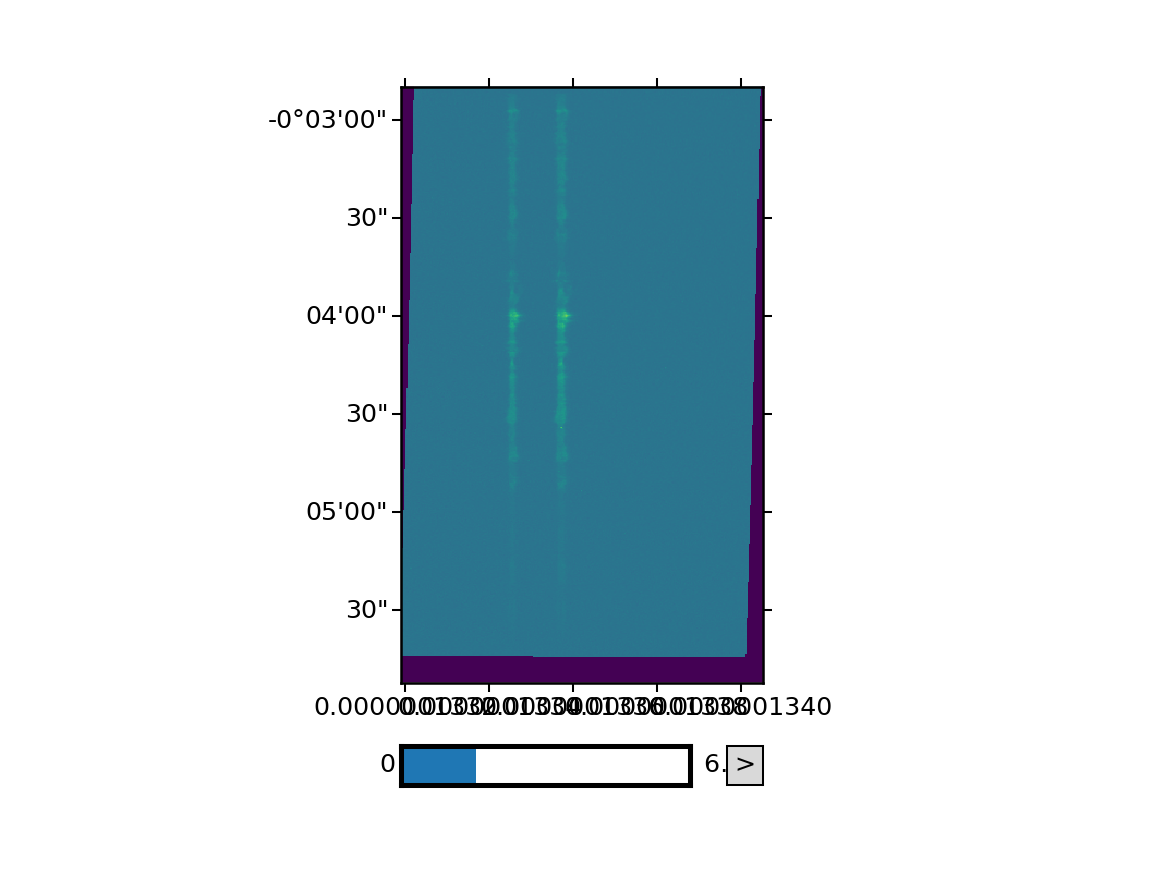

In [52]:
my_sequence.plot()